In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
from IPython.display import display

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.metrics import classification_report_imbalanced
from imblearn.base import SamplerMixin

print(__doc__)


Automatically created module for IPython interactive environment


In [2]:
def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_sample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
#     return Counter(y_res)


def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [3]:
df = pd.read_csv('data/train.csv').transpose()
df = df.reset_index()
# display(raw)
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header
df['label'] = [0,1,1,1,2,2,3,3,3,3]
display(df)

,label_name,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,label
1,dermal,0,188,30,55,1221,23,0,1593,0,...,115,334,176,540,229,274,1446,183,292,0
2,neuralTube,1,250,137,13,761,41,0,485,0,...,368,2482,147,235,334,462,305,215,588,1
3,neuralTube.1,9,418,149,22,1298,101,0,769,0,...,604,3528,234,387,461,638,509,353,1066,1
4,neuralTube.2,1,602,478,24,882,165,1215,797,0,...,365,4956,118,87,265,597,511,96,486,1
5,BAT,26,2704,211,32,2090,184,0,2188,0,...,1207,9029,349,1170,719,1412,4542,906,1397,2
6,BAT.1,18,1877,206,44,1895,118,0,1942,0,...,1041,7509,296,941,577,1476,2994,748,947,2
7,muscle,26,1178,243,41,3447,280,0,2204,0,...,2125,4322,401,1453,1215,1347,6908,567,1680,3
8,muscle.1,21,1145,355,33,2603,204,0,1899,0,...,2022,4321,437,828,742,1203,3478,288,1386,3
9,muscle.2,0,650,1102,113,955,0,1132,1118,0,...,0,4173,23,809,13,32,1358,0,0,3
10,muscle.3,11,377,797,317,1571,36,302,693,0,...,125,2530,111,39,299,284,1479,102,185,3


In [5]:
ros = RandomOverSampler(random_state=0)
smote = SMOTE(random_state=0)

predictors = [x for x in df.columns if x not in ['label_name', 'label']]
X = df[predictors]
y = df.label

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# normalize data: use minmax or standardize?
scaler = StandardScaler()
# scaler = MinMaxScaler()
x_transform = X.values.astype(float)
x_scaled = scaler.fit_transform(x_transform)

# print x_scaled
# print x_scaled.shape
    
X_resampled, y_resampled = ros.fit_sample(x_scaled, y)
# X_resampled, y_resampled = smote.fit_sample(x_scaled, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))
print X_resampled.shape

[(0, 4), (1, 4), (2, 4), (3, 4)]
(16, 20717)


In [6]:
def multiply(X,y, iteration):
    print 'mean & std'
    print X.mean(),X.std()
    new_X = X
    new_y = y
    for i in range(iteration):
        X_noise = np.random.normal(X.mean(),X.std(),X.shape)
        temp = X+X_noise
        new_X = np.vstack((new_X, temp ))
        new_y = np.vstack((new_y, y ))
    return new_X, new_y

In [7]:
# y_resampled = y_resampled.reshape((16,1))
X_multiplied,y_multiplied = multiply(X_resampled, y_resampled.reshape((16,1)), 20)
print X_multiplied.shape, y_multiplied.shape
print X_resampled.shape, y_resampled.shape

mean & std
-0.0251548368076 0.987144480384
(336, 20717) (336, 1)
(16, 20717) (16,)


In [8]:
# Make an identity sampler
class FakeSampler(SamplerMixin):

    def fit(self, X, y):
        self.ratio_ = 1
        self.X_hash_ = hash_X_y(X, y)
        return self

    def sample(self, X, y):
        return X,

    def _sample(self, X, y):
        pass

    def fit_sample(self, X, y):
        return X, y
    
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 15))
sampler = FakeSampler()
plot_resampling(X_resampled, y_resampled, sampler, ax1)
ax1.set_title('Original data - y={}'.format(Counter(y)))

plot_resampling(X_multiplied,y_multiplied, sampler, ax2)
ax2.set_title('Original data - y={}'.format(Counter(y)))

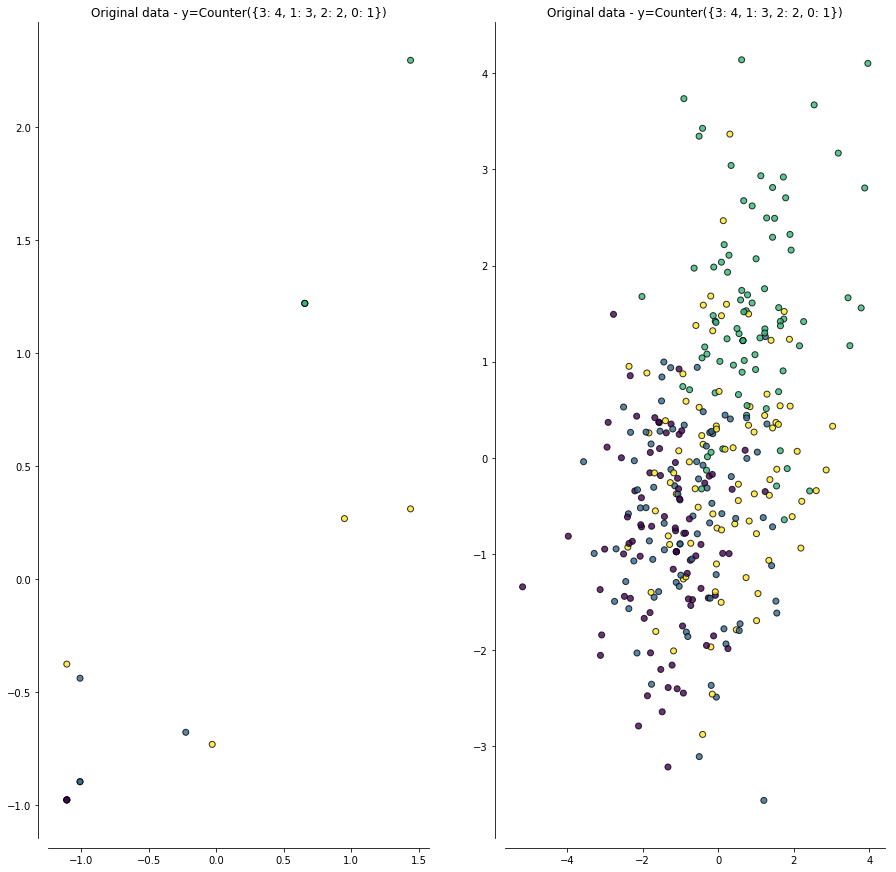

In [9]:
plt.show()